In [1]:
"""
Study of the effect of temperature and strain on the antenna frequencies of a high-temperature
microstrip patch antenna (MSPA) sensor
PUBLICATION: Microstrip patch antenna for simultaneous strain and temperature sensing
"""

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.multioutput import MultiOutputRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import r2_score as r2
np.set_printoptions(precision=6)
np.random.seed(42)
%matplotlib inline

In [2]:
# LOAD DATA FROM THE EXCEL
df = pd.read_csv('dT_s_dff_data.csv')

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 56000 entries, 0 to 55999
Data columns (total 4 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Temperature_change      56000 non-null  float64
 1   Strain_measurement      56000 non-null  float64
 2   Normalized_frequency10  56000 non-null  float64
 3   Normalized_frequency01  56000 non-null  float64
dtypes: float64(4)
memory usage: 1.7 MB


In [4]:
df.head(5)

,Temperature_change,Strain_measurement,Normalized_frequency10,Normalized_frequency01
0,-0.141924,0.157246,-5.418503,-5.678914
1,0.131695,0.008839,4.923361,5.336145
2,-0.089494,0.238904,-3.511231,-3.520846
3,0.001542,-1.009519,0.740149,-0.371845
4,0.160066,0.181621,5.868469,6.559324


In [5]:
df.describe()

,Temperature_change,Strain_measurement,Normalized_frequency10,Normalized_frequency01
count,56000.000000,56000.000000,56000.000000,56000.000000
mean,28.286053,175.000195,940.446521,1220.598614
std,18.014296,114.566054,678.705769,731.068946
min,-0.696728,-1.725203,-261.883664,-25.563465
25%,11.063125,86.362758,361.864960,563.259219
50%,29.000430,174.897738,966.944722,1249.464334
75%,45.938593,263.240181,1536.371452,1894.041172
max,55.739961,351.482352,2083.396170,2398.607469


In [6]:
# Note: You may need insider info to handle this dataset. Here is what you need to know.
# These are data from a dual-frequency antenna sensor. The inputs/measurands are the temperatures and
# the strain measurements. The antenna frequencies are simply the outputs/targets.

In [7]:
# Building input (X) and target/output (Y)
dT = df.Temperature_change
s = df.Strain_measurement
dff10 = df.Normalized_frequency10
dff01 = df.Normalized_frequency01
Y = np.c_[dff10, dff01]  # Targets
X = np.c_[dT, s]  # Features

In [8]:
print(f"The input shape:  {X.shape}")
print(f"The output shape:  {Y.shape}")

The input shape:  (56000, 2)
The output shape:  (56000, 2)


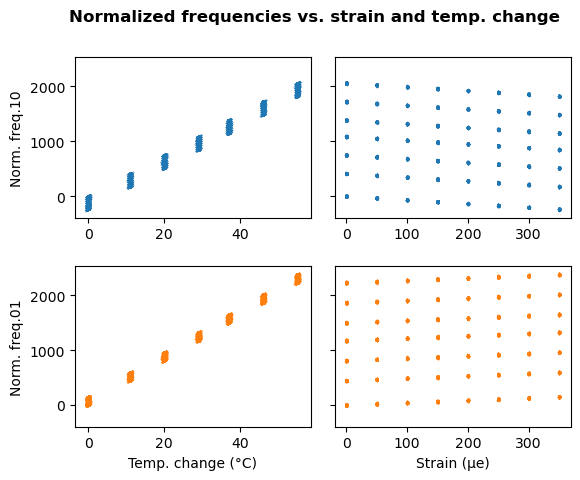

In [9]:
# Visualization
fig, ax = plt.subplots(2, 2, sharey=True)
colors = ['#1f77b4', '#ff7f0e']

for j in range(2):
    for i, a in enumerate(ax[j]):
        a.plot(X[:, i], Y[:, j], '.', markersize=0.5, color=colors[j])

ax[1, 0].set_xlabel('Temp. change (°C)')
ax[1, 1].set_xlabel('Strain (μe)')
ax[0, 0].set_ylabel('Norm. freq.10')
ax[1, 0].set_ylabel('Norm. freq.01')

fig.suptitle('Normalized frequencies vs. strain and temp. change', weight='bold', fontsize=12)
fig.subplots_adjust(wspace=0.1, hspace=0.3)

In [10]:
# Note: Both targets vary linearly with temperature and strain change. The ranges for the inputs significantly differ. We will have to do feature scaling.

In [11]:
# SPLIT DATA INTO TRAINING AND TEST DATASET 
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size=0.8, random_state=42)

In [12]:
scaler = StandardScaler()
X_train_norm = scaler.fit_transform(X_train)
X_test_norm = scaler.transform(X_test)  # Apply the same transformation to test data

In [13]:
print(f'Peak to peak before normalization:{np.ptp(X_train, axis=0)}')
print(f'Peak to after normalization:{np.ptp(X_train_norm, axis=0)}')

Peak to peak before normalization:[ 56.436689 353.207556]
Peak to after normalization:[3.135763 3.08324 ]


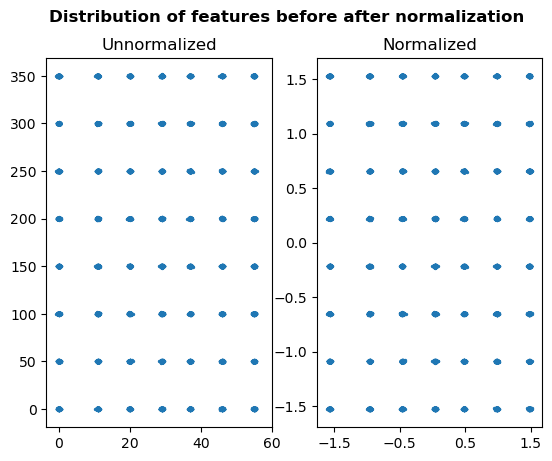

In [14]:
# Plot of features before and after scaling
fig, ax = plt.subplots(1, 2)
ax[0].scatter(X_train[:, 0], X_train[:, 1], s=2)
ax[1].scatter(X_train_norm[:, 0], X_train_norm[:, 1], s=2)
ax[0].set_title('Unnormalized')
ax[1].set_title('Normalized')
ax[0].set_xticks(np.arange(0, 65, 20))
ax[1].set_xticks(np.arange(-1.5, 2, 1))
fig.suptitle('Distribution of features before after normalization', weight='bold', fontsize=12)
plt.show()

In [15]:
# TRAINING THE MODEL
# Create a MultiOutputRegressor with linear regression and trian the model
linear = LinearRegression()
model = MultiOutputRegressor(linear)

In [16]:
# Fit the model on the training data
model.fit(X_train_norm, Y_train)

MultiOutputRegressor(estimator=LinearRegression())

In [17]:
# Extract the trained base regressors from MultiOutputRegressor
base_model = model.estimators_

# Initialize lists to store coefficients and intercepts
W = []  # Coefficients
b = []  # Intercepts

# Loop through each target's base regressor
for regressor in base_model:
    W.append(regressor.coef_)
    b.append(regressor.intercept_)

# Convert the lists to arrays
W = np.array(W)
b = np.array(b)

In [18]:
# Cost functions / Loss

J_train = mse(Y_train, model.predict(X_train_norm)) / 2  # Loss on the training set
Y_test_pred = model.predict(X_test_norm)
J_test = mse(Y_test, Y_test_pred) / 2  # Loss on the test set
score = model.score(X_test_norm, Y_test)  # R-squared score on training set

In [19]:
print(f'The loss on the training set: {J_train}')
print(f'The loss on the test set: {J_test}')

The loss on the training set: 2.3578673958764e-05
The loss on the test set: 2.3587944573780585e-05


In [20]:
model_score = model.score(X_test_norm, Y_test)
print(f'Overall model score: {model_score}')

Overall model score: 0.9999999999123419


In [21]:
#score per estimator
scores = r2(Y_test, Y_test_pred, multioutput="raw_values")
formatted_scores = ", ".join([f"{score:.12f}" for score in scores])
print(f'Model score per estimator: {formatted_scores}')

Model score per estimator: 0.999999999999, 0.999999999825


In [22]:
print(f'The model parameters when features are normalized: \nW:{W} \nb:\n{b}')

The model parameters when features are normalized: 
W:[[673.653716 -77.438719]
 [728.735651  49.282924]] 
b:
[ 941.667937 1221.710895]


In [23]:
# Original scaler parameters
mean = scaler.mean_  # Mean
scale = scaler.scale_ # Std. deviation

# Reverse transformation
W_original = W / scale # Weights if the features were not scaled

print(f"The original weights: \nW:{W_original}")
    

The original weights: 
W:[[37.429882 -0.675983]
 [40.490371  0.430203]]
